In [1]:
import pandas as pd
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [2]:
sales_df = pd.read_csv(
    "../newData.csv",
    dtype={
        'Store': 'category',
        'BaseUPC': 'category',
    },
    parse_dates=['SalesDate'],
    infer_datetime_format=True,
)

In [3]:
sales_df['SalesDate'] = sales_df.SalesDate.dt.to_period('D')
filtered_sales_df = sales_df.set_index(['Store', 'SalesDate', 'BaseUPC'])

In [4]:
data = filtered_sales_df.unstack(['Store', 'BaseUPC'])
data.index = data.index.to_timestamp()
data_new_index = pd.date_range(start=data.index.min(), end=data.index.max(), name='SalesDate')
data = data.reindex(data_new_index)
data.fillna(0, inplace=True)
data.index = data.index.to_period(freq='D')
data = data.stack(['Store', 'BaseUPC'])
data = data.unstack(['SalesDate'])
data = data.stack(['SalesDate'])

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [6]:
### Target series
y = data.unstack(['Store', 'BaseUPC']).loc[:, 'total_sales']


# X_1: Features for Linear Regression
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

X1 = dp.in_sample()

In [7]:
# y.to_csv('out_origin.csv')

In [8]:
X1['NewYear'] = (X1.index.dayofyear == 1)
X1["day"] = X1.index.day
X1["month"] = X1.index.month
X1["year"] = X1.index.year
X1["day_of_week"] = X1.index.dayofweek
X1["day_of_year"] = X1.index.dayofyear


# X_2: Features for XGBoost
X2 = data.reset_index(level=['BaseUPC', 'Store'])
X2.drop(columns='total_sales', inplace=True)

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X2['BaseUPC'] = le.fit_transform(X2['BaseUPC'])
X2.reset_index(inplace=True)


X2["day"] = X2.SalesDate.dt.day
X2["month"] = X2.SalesDate.dt.month
X2["year"] = X2.SalesDate.dt.year
X2["day_of_week"] = X2.SalesDate.dt.dayofweek
X2["day_of_year"] = X2.SalesDate.dt.dayofyear

X2.set_index('SalesDate', inplace=True)
X2['Store'] = X2['Store'].astype(int)


In [9]:
scaler_1 = MinMaxScaler()
scaler_2 = MinMaxScaler()
X1_norm = scaler_1.fit_transform(X1)
X2_norm = scaler_2.fit_transform(X2)
X1 = pd.DataFrame(X1_norm, index=X1.index, columns=X1.columns)
X2 = pd.DataFrame(X2_norm, index=X2.index, columns=X2.columns)

y_train, y_valid = y[:"2023-08-03"], y["2023-08-04":]
X1_train, X1_valid = X1[:"2023-08-03"], X1["2023-08-04":]
X2_train, X2_valid = X2[X2.index <= "2023-08-03"], X2[X2.index > "2023-08-03"]

In [10]:
X2 = pd.concat([X2_train, X2_valid])

In [ ]:
y_train_one = y_train[[('00344', '0000000003035')]]
y_valid_one = y_valid[[('00344', '0000000003035')]]

In [11]:
result_dict = dict()

# Linear Regression

In [12]:
model_linear = LinearRegression(fit_intercept=False)
history = model_linear.fit(X1_train, y_train)
y_fit = pd.DataFrame(model_linear.predict(X1_train), index=X1_train.index, columns=y_train.columns)
y_pred = pd.DataFrame(model_linear.predict(X1_valid), index=X1_valid.index, columns=y_valid.columns)
result_dict['linear'] = (y_fit, y_pred,)
y_linear = pd.concat([y_fit, y_pred])
# y_linear.to_csv('out_linear.csv')

# Lasso

In [13]:
model_lasso = Lasso(fit_intercept=False)
history = model_lasso.fit(X1_train, y_train)
y_fit = pd.DataFrame(model_lasso.predict(X1_train), index=X1_train.index, columns=y_train.columns)
y_pred = pd.DataFrame(model_lasso.predict(X1_valid), index=X1_valid.index, columns=y_valid.columns)
result_dict['lasso'] = (y_fit, y_pred,)
y_lasso = pd.concat([y_fit, y_pred])
# y_lasso.to_csv('out_lasso.csv')

C:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.754e+03, tolerance: 3.277e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

In [149]:
X2_train

,Store,BaseUPC,day,month,year,day_of_week,day_of_year
SalesDate,,,,,,,
2023-07-14,0.0,0.000113,0.433333,0.0,0.0,0.666667,0.000000
2023-07-15,0.0,0.000113,0.466667,0.0,0.0,0.833333,0.037037
2023-07-16,0.0,0.000113,0.500000,0.0,0.0,1.000000,0.074074
2023-07-17,0.0,0.000113,0.533333,0.0,0.0,0.000000,0.111111
2023-07-18,0.0,0.000113,0.566667,0.0,0.0,0.166667,0.148148
...,...,...,...,...,...,...,...
2023-07-30,1.0,0.712833,0.966667,0.0,0.0,1.000000,0.592593
2023-07-31,1.0,0.712833,1.000000,0.0,0.0,0.000000,0.629630
2023-08-01,1.0,0.712833,0.000000,1.0,0.0,0.166667,0.666667


# Ridge

In [14]:
model_ridge = Ridge(fit_intercept=False)
history = model_ridge.fit(X1_train, y_train)
y_fit = pd.DataFrame(model_ridge.predict(X1_train), index=X1_train.index, columns=y_train.columns)
y_pred = pd.DataFrame(model_ridge.predict(X1_valid), index=X1_valid.index, columns=y_valid.columns)
result_dict['ridge'] = (y_fit, y_pred,)
y_ridge = pd.concat([y_fit, y_pred])
# y_ridge.to_csv('out_ridge.csv')

# ElasticNet

In [15]:
model_elasticnet = ElasticNet(fit_intercept=False)
history = model_elasticnet.fit(X1_train, y_train,)
y_fit = pd.DataFrame(model_elasticnet.predict(X1_train), index=X1_train.index, columns=y_train.columns)
y_pred = pd.DataFrame(model_elasticnet.predict(X1_valid), index=X1_valid.index, columns=y_valid.columns)
result_dict['elasticnet'] = (y_fit, y_pred,)
y_elasticnet = pd.concat([y_fit, y_pred])
# y_elasticnet.to_csv('out_elastic.csv')

C:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


In [16]:
def metric(y_origin: pd.DataFrame, y_pred: pd.DataFrame, index_name: str):
    error = []
    max_count = []
    for column in y_origin.columns:
        maximum = y_origin[column].max()
        if maximum < 5:
            max_count.append(maximum)
            error.append(1e2)
        else:
            max_count.append(maximum)
            err = mean_squared_error(y_origin.loc[:"2023-08-03"][column], y_pred.loc[:"2023-08-03"][column])
            error.append(err)
        
    return pd.DataFrame([error, max_count], index=[index_name, index_name + "_max"], columns=y_origin.columns)

In [17]:
err_linear = metric(y, y_linear, 'linear')
err_lasso = metric(y, y_lasso, 'lasso')
err_ridge = metric(y, y_ridge, 'ridge')
err_elasticnet = metric(y, y_elasticnet, 'elasticnet')
err_total = pd.concat([err_linear, err_lasso, err_ridge, err_elasticnet])
err_total = err_total.drop(['linear_max', 'ridge_max', 'elasticnet_max'])
err_total.to_csv('mse_new.csv')

In [19]:
result = err_total = err_total.drop(['linear_max', 'ridge_max', 'elasticnet_max']).transpose()
result

linear        lasso  lasso_max        ridge  \
Store BaseUPC                                                           
00344 0000000002502     9.214861    25.238984       29.0    13.459024   
      0000000002505    28.884908   151.640423       69.0   122.475026   
      0000000002510   100.000000   100.000000        0.0   100.000000   
      0000000002594   100.000000   100.000000        2.0   100.000000   
      0000000002596   100.000000   100.000000        3.0   100.000000   
...                          ...          ...        ...          ...   
00948 0079871616253   108.389009   248.544850       96.0   218.303991   
      0079871617363  1514.690629  2300.090638      192.0  2342.200713   
      0002310011024     0.587480     1.714286        6.0     0.840106   
      0004390018649    37.598751    77.170167       48.0    53.766765   
      0007726010553     0.000000     0.000000        9.0     0.000000   

                      elasticnet  
Store BaseUPC                     
00344 0000000002502    27.035886  
      0000000002505   227.583772  
      0000000002510   100.000000  
      0000000002594   100.000000  
      0000000002596   100.000000  
...                          ...  
00948 0079871616253   346.038893  
      0079871617363  3032.626481  
      0002310011024     1.714286  
      0004390018649    88.301391  
      0007726010553     0.000000  

[146797 rows x 5 columns]

In [20]:
def plot_one(model: str, upc: str, store: str):
    y_fit, y_pred = result_dict[model]
    y_fit_one = y_fit.loc[:, [(store, upc)]]
    y_pred_one = y_pred.loc[:, [(store, upc)]]
    ax = y.loc[:, store].loc[:, upc].plot(
        figsize=(11, 9), alpha=0.5,
    )
    _ = y_fit_one.loc[:, store].loc[:, upc].plot(color='C1', alpha=0.5)
    _ = y_pred_one.loc[:, store].loc[:, upc].plot(color='C3', alpha=0.5)
    ax.legend([])
    ax.set_ylabel(upc)

In [138]:
def plot_all_models(upc: str, store: str, plot: bool = True):
    y_origin_one = y.loc[:, store].loc[:, upc].to_frame()
    y_origin_one.columns = ['sales']
    y_origin_one.reset_index(inplace=True)
    y_origin_one['SalesDate'] = y_origin_one.SalesDate.dt.to_timestamp()
    mse = pd.DataFrame()
    if plot:
        axs = y_origin_one.plot(
            subplots=True, sharex=True, figsize=(11, 9), alpha=1, x='SalesDate', y='sales', kind='scatter'
        )
    for i, (model) in enumerate(result_dict.keys()):
        if model != 'lasso':
            continue
        y_fit, y_pred = result_dict[model]
        y_fit_one = y_fit.loc[:, [(store, upc)]]
        y_pred_one = y_pred.loc[:, [(store, upc)]]
        y_model = pd.concat([y_fit_one, y_pred_one])
        mse[model] = [mean_squared_error(y_origin_one['sales'], y_model[(store, upc,)])]
        if plot:
            _ = y_fit_one.loc[:, store].loc[:, upc].plot(subplots=True, color=f'C{i + 1}', alpha=0.5, ax=axs)
            _ = y_pred_one.loc[:, store].loc[:, upc].plot(subplots=True, color=f'C{i + 1}', alpha=1, ax=axs)
    
    # Prophet
    y_train_one = y_train[[(store, upc)]]
    y_valid_one = y_valid[[(store, upc)]]
    y_train_one.index.names = ['ds']
    y_train_one.columns = ['y']
    y_train_one.reset_index(inplace=True)
    y_train_one['ds'] = y_train_one.ds.dt.to_timestamp()
    m = Prophet()
    m.fit(y_train_one)
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)
    y_model = forecast.loc[:, ['ds', 'yhat']]
    mse['prophet'] = [mean_squared_error(y_origin_one.tail(7)['sales'], y_model.tail(7)['yhat'])]
    if plot:
        y_model.plot(x='ds', y='yhat', ax=axs, subplots=True, color=f'C{i + 2}')
    
    # ARIMA
    model = pm.ARIMA((7,0,1), (0,0,0,7),)
    # model = pm.auto_arima(y_train_one['y'], seasonal=True, d=7, trace=True)
    model.fit(y_train_one['y'])
    # print(y_train_one['y'])
    y_fit = model.predict_in_sample().to_frame()
    y_fit.columns = ['y']
    y_fit['ds'] = y_train_one['ds']
    # y_fit['ds'] = y_fit.ds.dt.to_timestamp()
    y_pred = model.predict(7).to_frame()
    y_pred.columns = ['y']
    y_pred['ds'] = y_valid_one.index
    y_pred['ds'] = y_pred.ds.dt.to_timestamp()
    y_model = pd.concat([y_fit, y_pred])
    if plot:
        y_model.plot(x='ds', y='y', ax=axs, subplots=True, color=f'C{i + 3}')
    mse['arima'] = [mean_squared_error(y_origin_one.tail(7)['sales'], y_model.tail(7)['y'])]
    if plot:
        for ax in axs:
            ax.legend([])
            ax.set_ylabel(upc)
    return mse

In [35]:
result.sort_values(by='lasso_max', ascending=False)

linear        lasso  lasso_max         ridge  \
Store BaseUPC                                                           
00423 0001111036838   97.200268  2763.242039     1508.0  12812.527028   
00915 0001111036838  189.221372  1380.718853     1344.0   6470.613548   
      0000000004011  371.476625   979.341447     1272.0   3964.020703   
00423 0000000004011  321.434281  1179.531274     1242.0   3650.013495   
00409 0001111036838  133.866829  1291.640324      902.0   4097.979572   
...                         ...          ...        ...           ...   
00915 0000000078011  100.000000   100.000000        0.0    100.000000   
00402 0000000004565  100.000000   100.000000        0.0    100.000000   
00432 0007247000383  100.000000   100.000000        0.0    100.000000   
00943 0001901480229  100.000000   100.000000        0.0    100.000000   
00946 0000000026712  100.000000   100.000000        0.0    100.000000   

                       elasticnet  
Store BaseUPC                      
00423 0001111036838  79757.151463  
00915 0001111036838  50136.389687  
      0000000004011  36627.765275  
00423 0000000004011  37230.882923  
00409 0001111036838  27633.228922  
...                           ...  
00915 0000000078011    100.000000  
00402 0000000004565    100.000000  
00432 0007247000383    100.000000  
00943 0001901480229    100.000000  
00946 0000000026712    100.000000  

[146797 rows x 5 columns]

In [62]:
sorted_result = result.sort_values(by='lasso_max', ascending=False)

In [140]:
sorted_result.to_csv('mse_lasso.csv')

In [103]:
mse_list = []
error_list = []
i = 0
for store, upc in sorted_result.index:
    i += 1
    try:
        mse = plot_all_models(upc, store, plot=False)
    except:
        error_list.append((store, upc))
        continue
    mse['store'] = [store]
    mse['upc'] = [upc]
    mse_list.append(mse)
    if i >= 100:
        break

C:\Users\pc\AppData\Local\Temp\ipykernel_18796\1227150964.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_one['ds'] = y_train_one.ds.dt.to_timestamp()
01:58:06 - cmdstanpy - INFO - Chain [1] start processing
01:58:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pc\AppData\Local\Temp\ipykernel_18796\1227150964.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [104]:
pd.concat(mse_list)

,lasso,prophet,arima,store,upc
0,68396.248605,1111.463939,1626.915918,00423,0001111036838
0,67899.283524,23150.319544,8482.527438,00915,0001111036838
0,9281.108438,1682.902220,3779.722951,00915,0000000004011
0,9809.178755,715.628026,1401.786760,00423,0000000004011
0,33662.986467,3425.637971,6498.554262,00409,0001111036838
...,...,...,...,...,...
0,1402.530858,72.083450,115.408794,00423,0000000023108
0,586.700062,7136.366912,2895.314168,00943,0001111049213
0,3146.296127,8739.290259,9285.051153,00943,0000000004046
0,1641.402594,6620.372171,1201.594319,00915,0000000004258


C:\Users\pc\AppData\Local\Temp\ipykernel_18796\1560581438.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_one['ds'] = y_train_one.ds.dt.to_timestamp()
10:47:13 - cmdstanpy - INFO - Chain [1] start processing
10:47:13 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

,lasso,prophet,arima
0,33662.986467,3425.637971,6498.554262


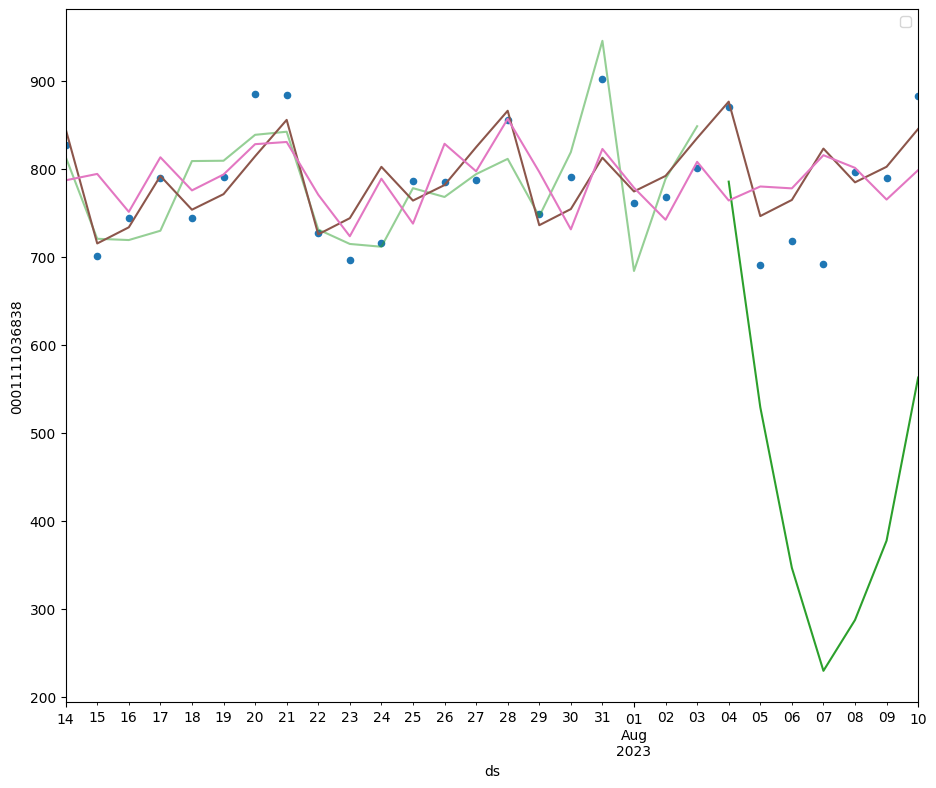

In [148]:
plot_all_models(upc='0001111036838', store='00409')

In [ ]:
y_train_one.index.names = ['ds']
y_train_one.columns = ['y']
y_train_one.reset_index(inplace=True)

# Prophet

In [ ]:
m = Prophet()
m.fit(y_train_one)
# y_train_one.
future = m.make_future_dataframe(periods=7)

In [ ]:
forecast = m.predict(future)

In [ ]:
forecast.loc[:, ['total_sales', 'SalesDate']]

In [ ]:
forecast.loc[:, ['total_sales', 'SalesDate']].plot(x='SalesDate', y='total_sales')

In [ ]:
y_train_one = y_train[[('00344', '0000000003035')]]
y_train_one.index.names = ['ds']
y_train_one.columns = ['y']
y_train_one.reset_index(inplace=True)
y_train_one['ds'] = y_train_one.ds.dt.to_timestamp()
y_train_one

# ADVANCED

In [ ]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

In [ ]:
def fit(self, X_1, X_2, y):
    # YOUR CODE HERE: fit self.model_1
    self.model_1.fit(X_1, y)
    
    y_fit = pd.DataFrame(
        # YOUR CODE HERE: make predictions with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    # YOUR CODE HERE: compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack(['Store', 'BaseUPC']).squeeze() # wide to long

    # YOUR CODE HERE: fit self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)
    #cross_val_score(self.model_2, X_2, y_resid, cv=5)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

In [ ]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        # YOUR CODE HERE: predict with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack(['Store', 'BaseUPC']).squeeze()  # wide to long

    # YOUR CODE HERE: add self.model_2 predictions to y_pred
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack(['Store', 'BaseUPC'])  # long to wide


# Add method to class
BoostedHybrid.predict = predict

In [ ]:
xgb_params = {
    'max_depth':10,           # maximum depth of each tree - try 2 to 10
    'learning_rate':0.01,    # effect of each tree - try 0.0001 to 0.1
    'n_estimators':1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    'min_child_weight':1,    # minimum number of houses in a leaf - try 1 to 10
    'colsample_bytree':0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    'subsample':0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    'reg_alpha':0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    'reg_lambda':1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    'num_parallel_tree':1,
}

mlp_params = {
    'alpha':0.0001,
    'early_stopping':True,
}


mlp_deep_params = {
    'hidden_layer_sizes':512,
    'activation':'tanh',
    'early_stopping':True,
    'alpha':0.0001
}